# Generating EOS
This notebook generates tables of EOSs including a QCD and a vacuum energy phase transition, giving pressure and energy density in G=c=M_sun=1 units. After appropriate rescaling of the final quantities, it can be used in well-known NS integrator, like the RNS code (https://github.com/cgca/rns).

## Import

In [1]:
using DelimitedFiles, Interpolations, Symbolics, Printf, Plots, LaTeXStrings

## Load data and useful constants

In [3]:
#LOADING DATA
#Note: the usual dataset for the AP4 and the SLy gave all quantities in g/cm^3
#The dataset in Rescaledsly.dat and Rescaledap4.dat have been rescaled to G=c=M_Sun=1
#The data for the (ρ,c_s) segments are also in G=c=M_Sun=1
#Smaller dataset corresponds to matrixrhoS.dat and matrixcsS.dat
#Larger dataset corresponds to matrixrhoL.dat and matrixcsL.dat
sly = readdlm("Rescaledsly.dat", Float64) #p,ϵ,ρ
ap4 = readdlm("Rescaledap4.dat", Float64); #p,ϵ,ρ
matrix_ρ = readdlm("matrixrhoS.dat", Float64) #loading ρ coordinates for segments
matrix_cs = readdlm("matrixcsS.dat", Float64); #loading cs coordinates for segments
#matrix_ρ = readdlm("matrixrhoL.dat", Float64) #loading ρ coordinates for segments
#matrix_cs = readdlm("matrixcsL.dat", Float64); #loading cs coordinates for segments

In [3]:
#USEFUL CONSTANTS FOR RESCALING UNITS
const cspeed = 2.997 * 10.0^10 #in cm s^-1
const hbar = 6.582 * 10.0^-22 #in Mev s
const MeV = 1.602 * 10.0^-6 #in g cm^2 s^-1
const Kp = MeV/(hbar^3 * cspeed^3) #transforming a pressure in Mev^4 in g/cm/s^2
const Kρ = MeV/(hbar^3 * cspeed^5) #transforming a mass density in Mev^4 in g/cm^3
const fm = (10.0^-13)^-3 #fm^-3 in cm^-3
const n0 = 0.16 * fm #nuclear saturation density in cm^-3
const m = 1.675 * 10.0^-24 #neutron mass in g
const Msun = 1.988 * 10.0^33 #mass of the Sun in g
const Gconst = 6.67 * 10.0^-11 * 10.0^6/10.0^3 #in cm^3/g/s^2
const Lu = Msun^-1 * cspeed^2 * Gconst^-1 #1cm in G=c=Msun=1
const Pu = Msun^-1 / Lu^3 / cspeed^2  #transforming a pressure in g/cm/s^2 in G=c=Msun=1 units
const ρu = Msun^-1 / Lu^3; #transforming a mass density in g/cm^3 in G=c=Msun=1 units

## Functions

In [4]:
#function to find (closest) position in array of certain value 
#!!It works for increasing values on column!!
function findpos(matrix,value,column)
    K = length(matrix[:,column])
    
    #check if element is in list
    if value > matrix[end,column] || value < matrix[1,column] 
        return 0
    end
    
    for b = 1:length(matrix[:,column])
        Δx1 = abs(matrix[b,column]  - value)
        Δx2 = abs(matrix[b+1,column] - value)
        if matrix[b+1,column] >= value
            if Δx1 < Δx2
                return b
            else
                return b+1
            end
        end
    end
end;

In [16]:
#Evaluating derivative functions to find quantities at threshold
function derThr(eos, k)
    s = 0.
    for j = 1:k
        Δp = eos[j+1,1] - eos[j,1]
        Δϵ = eos[j+1,2] - eos[j,2]
        s = Δp/Δϵ
    end
    return s
end

#creating an interpolated function for speed of sound modification
function csInterp(eos, k, p1, matr_ρ, matr_cs, ds)
    #define matrix to store (ρ,cs) for segments modification
    segm_matrix = Matrix{Float64}(undef,0,2) 
    segm_matrix = vcat(segm_matrix, [eos[k,3] p1])
    for j = 1:7
      segm_matrix = vcat(segm_matrix, [matr_ρ[ds,j] matr_cs[ds,j]])  
    end
    return linear_interpolation(segm_matrix[:,1],segm_matrix[:,2])
end

#create high energy eos
function heEOS(he_eos::AbstractMatrix{T}, eos, k, cs_interp) where T
    Δρ = 10.0^-5
    M = div((10.0^-3 - eos[k,3]),10.0^-5)+div((10.0^-2 - 10.0^-3),10.0^-4)+
        div((ρfin - 10.0^-2),10.0^-3)    
    ρold = eos[k,3]
    ϵold = eos[k,2]
    pold = eos[k,1]
    
    for j = 1:M-1
        ρnew = ρold + Δρ
        ϵnew = ϵold + Δρ * (ϵold + pold)/ρold
        pnew = pold + cs_interp(ρold)^2 * Δρ * (ϵold + pold)/ρold #cs^2=dp/dϵ
        if ρnew > ρfin #break cycle if we reach last mass density
            break
        end
        he_eos = vcat(he_eos, [pnew ϵnew ρnew])
        ρold = ρnew #store new data in old variable for next loop
        ϵold = ϵnew
        pold = pnew
        if ρnew < 10.0^-3
            Δρ = 10.0^-5
        elseif ρnew < 10.0^-2
            Δρ = 10.0^-4
        elseif ρnew < 10^-1
            Δρ = 10.0^-3
        else 
            Δρ = 10.0^-2
        end
    end
    return he_eos
end

#merge two EOS
function mergeEOS(eos_matrix::AbstractMatrix{T}, he_eos, eos, k) where T
    N = k + length(he_eos[:,1])
    for j = 1:N
        if j <= k
            eos_matrix = vcat(eos_matrix, [eos[j,1] eos[j,2] eos[j,3]])
        else
            eos_matrix = vcat(eos_matrix, [he_eos[j-k,1] he_eos[j-k,2] he_eos[j-k,3]])
        end 
    end
    return eos_matrix
end

#BUILDING EOS before Λ transition
function build(eos_matrix::AbstractMatrix{T}, eos, matr_ρ, matr_cs, ds) where T
    #find quantities at transition threshold
    k = findpos(eos,ρt,3) #find closest position of ρt
    #@show eos[k,1] #shows pressure at QCD threshold

    #Evaluating derivative functions to find quantities at threshold
    p1 = derThr(eos, k)
   
    #creating an interpolated function for speed of sound modification
    cs_interp = csInterp(eos, k, p1, matr_ρ, matr_cs, ds)
    
    #define matrix to store new part of eos
    he_eos = Matrix{Float64}(undef,0,3)
    he_eos = heEOS(he_eos, eos, k, cs_interp)
    
    #merge the two eos at right threshold
    eos_matrix = mergeEOS(eos_matrix, he_eos, eos, k)
    return eos_matrix
end;

In [6]:
#Introducing Λ transition
function Λtransition(eos_complete::AbstractMatrix{T}, matr) where T
    k = findpos(matr,pc,1) #find line in matrix corrisponding to pc
    
    #NB: p<pc total=fluid, p>pc total=fluid+Λ contribution
    for j=1:length(matr[:,1])
        if j < k
            eos_complete = vcat(eos_complete, [matr[j,1] matr[j,2]])
        elseif j >= k
            pfluid = matr[j,1] + Λ
            #if it goes outside of tables, it stops.
            if Λ >= 0 && pfluid > matr[end,1] 
                break
            end
            if Λ < 0 && pfluid < matr[1,1]
                break
            end
            #find closest position of pfluid in tables, and corresponding energy density
            l = findpos(matr,pfluid,1)
            eos_complete = vcat(eos_complete, [matr[j,1] matr[l,2]+Λ])
        end
    end
    return eos_complete
end;

## Computation

In [7]:
const ρt = 2.0 * n0 * m * ρu #mass density when QCD transition happens
const ρfin = 12.0 * n0 * m * ρu #highest mass density we decide to reach for QCD part
const pc = 200.0^4 * Kp *Pu #threshold corresponds to QCD scale
#Possible values of Λ
Λarray = [-194^4 * Kp * Pu, -150^4 * Kp * Pu, -120^4 * Kp * Pu, -95^4 * Kp * Pu,
    -50^4 * Kp * Pu, 0.0, 50^4 * Kp * Pu, 95^4 * Kp * Pu, 120^4 * Kp * Pu, 194^4 * Kp * Pu];

In [18]:
Λ = Λarray[10] #Vacuum energy shift value from array
z=45 #For small dataset between (1,100), for larger between (1,1000)
#Choose low-density EOS
eos = ap4 #sly

#Introduce QCD phase into EOS - choose dataset in "Load data and useful constants"
eos_matrix = Matrix{Float64}(undef,0,3)
eos_matrix = build(eos_matrix, eos, matrix_ρ, matrix_cs, z)

#The following gives matrix for complete eos, including Λ transition: 
#1) pressure, 2) energy density, both quantities are in c=G=M_sun=1 units
#to restore units to g/cm^3 divide values by ρu, given in "Load data and useful constants"
eos_complete = Matrix{Float64}(undef,0,2)
eos_complete = Λtransition(eos_complete, eos_matrix);

In [ ]:
#Store complete EOS
writedlm( "NAME.csv",  eos_complete, ' ')

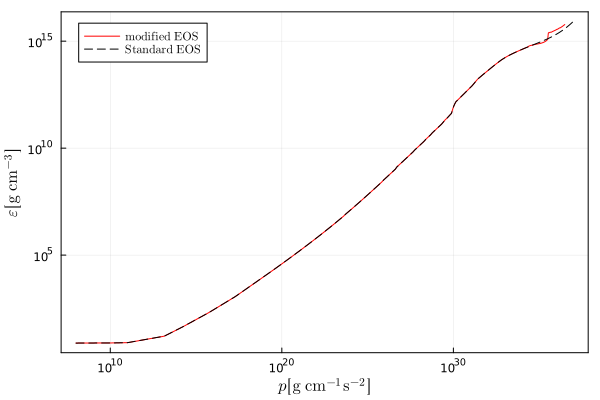

In [24]:
#Plot EOS in g,cm,s units
plot(eos_complete[:,1]./Pu,eos_complete[:,2]./ρu, xscale=:log10,yscale=:log10, 
    color=:red, framestyle=:box, label=L"\textrm{modified\ EOS}", legend=:topleft,
     xlabel=L"p[\textrm{g\ cm^{-1} s^{-2}}]", ylabel=L"\epsilon[\textrm{g\ cm^{-3}}]")
plot!(eos[:,1]./Pu,eos[:,2]./ρu, xscale=:log10,yscale=:log10, color=:black,
    linestyle=:dash, label=L"\textrm{Standard \ EOS}")